In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path
ROOTDIR = Path('/home/virginia/workspace/topic-modeling-study/')
NUM_TOPICS = [50, 100]
CORPORA = {'rnc':'ru', 'opencorpora':'ru', 'tiger':'de'}
PREPROCESSORS = {'ru':["oracle", "raw", "pymystem3", "snowball", "stanza", "truncate5", "truncate6"], 
                 'de':["oracle", "raw", "spacy", "snowball", "stanza", "truncate5", "truncate6"]}
NUM_EXPERIMENTS=10


def get_path_to_results(corpus, n, p, measure_type, postProc=None, count=None):
    """
    :param corpus: str, name of corpus
    :param n: str or int, number of topics
    :param p: str, name of treatment
    :param measure_type: the basename name of measurement TSV file
    :param postProc: str, use for post stemming
    :param count: int, experiment id number
    """
    #print(n, p, postProc, count)
    if p=="":
        prefix = f'{corpus}_{n}topics_1000iters'
    else:
        prefix = f'{corpus}_{p}_{n}topics_1000iters'

    if count is not None:
        prefix = f'{prefix}_{count}' 
        
    # TODO Figure out what to do with post proc
    if postProc:
        return ROOTDIR / f'{corpus}/{corpus}_{postProc}_post/{prefix}_{postProc}_post_{measure_type}.tsv'
    else:
        return ROOTDIR /f'{corpus}/{corpus}_{p}/{prefix}/{corpus}_{p}_{measure_type}.tsv'


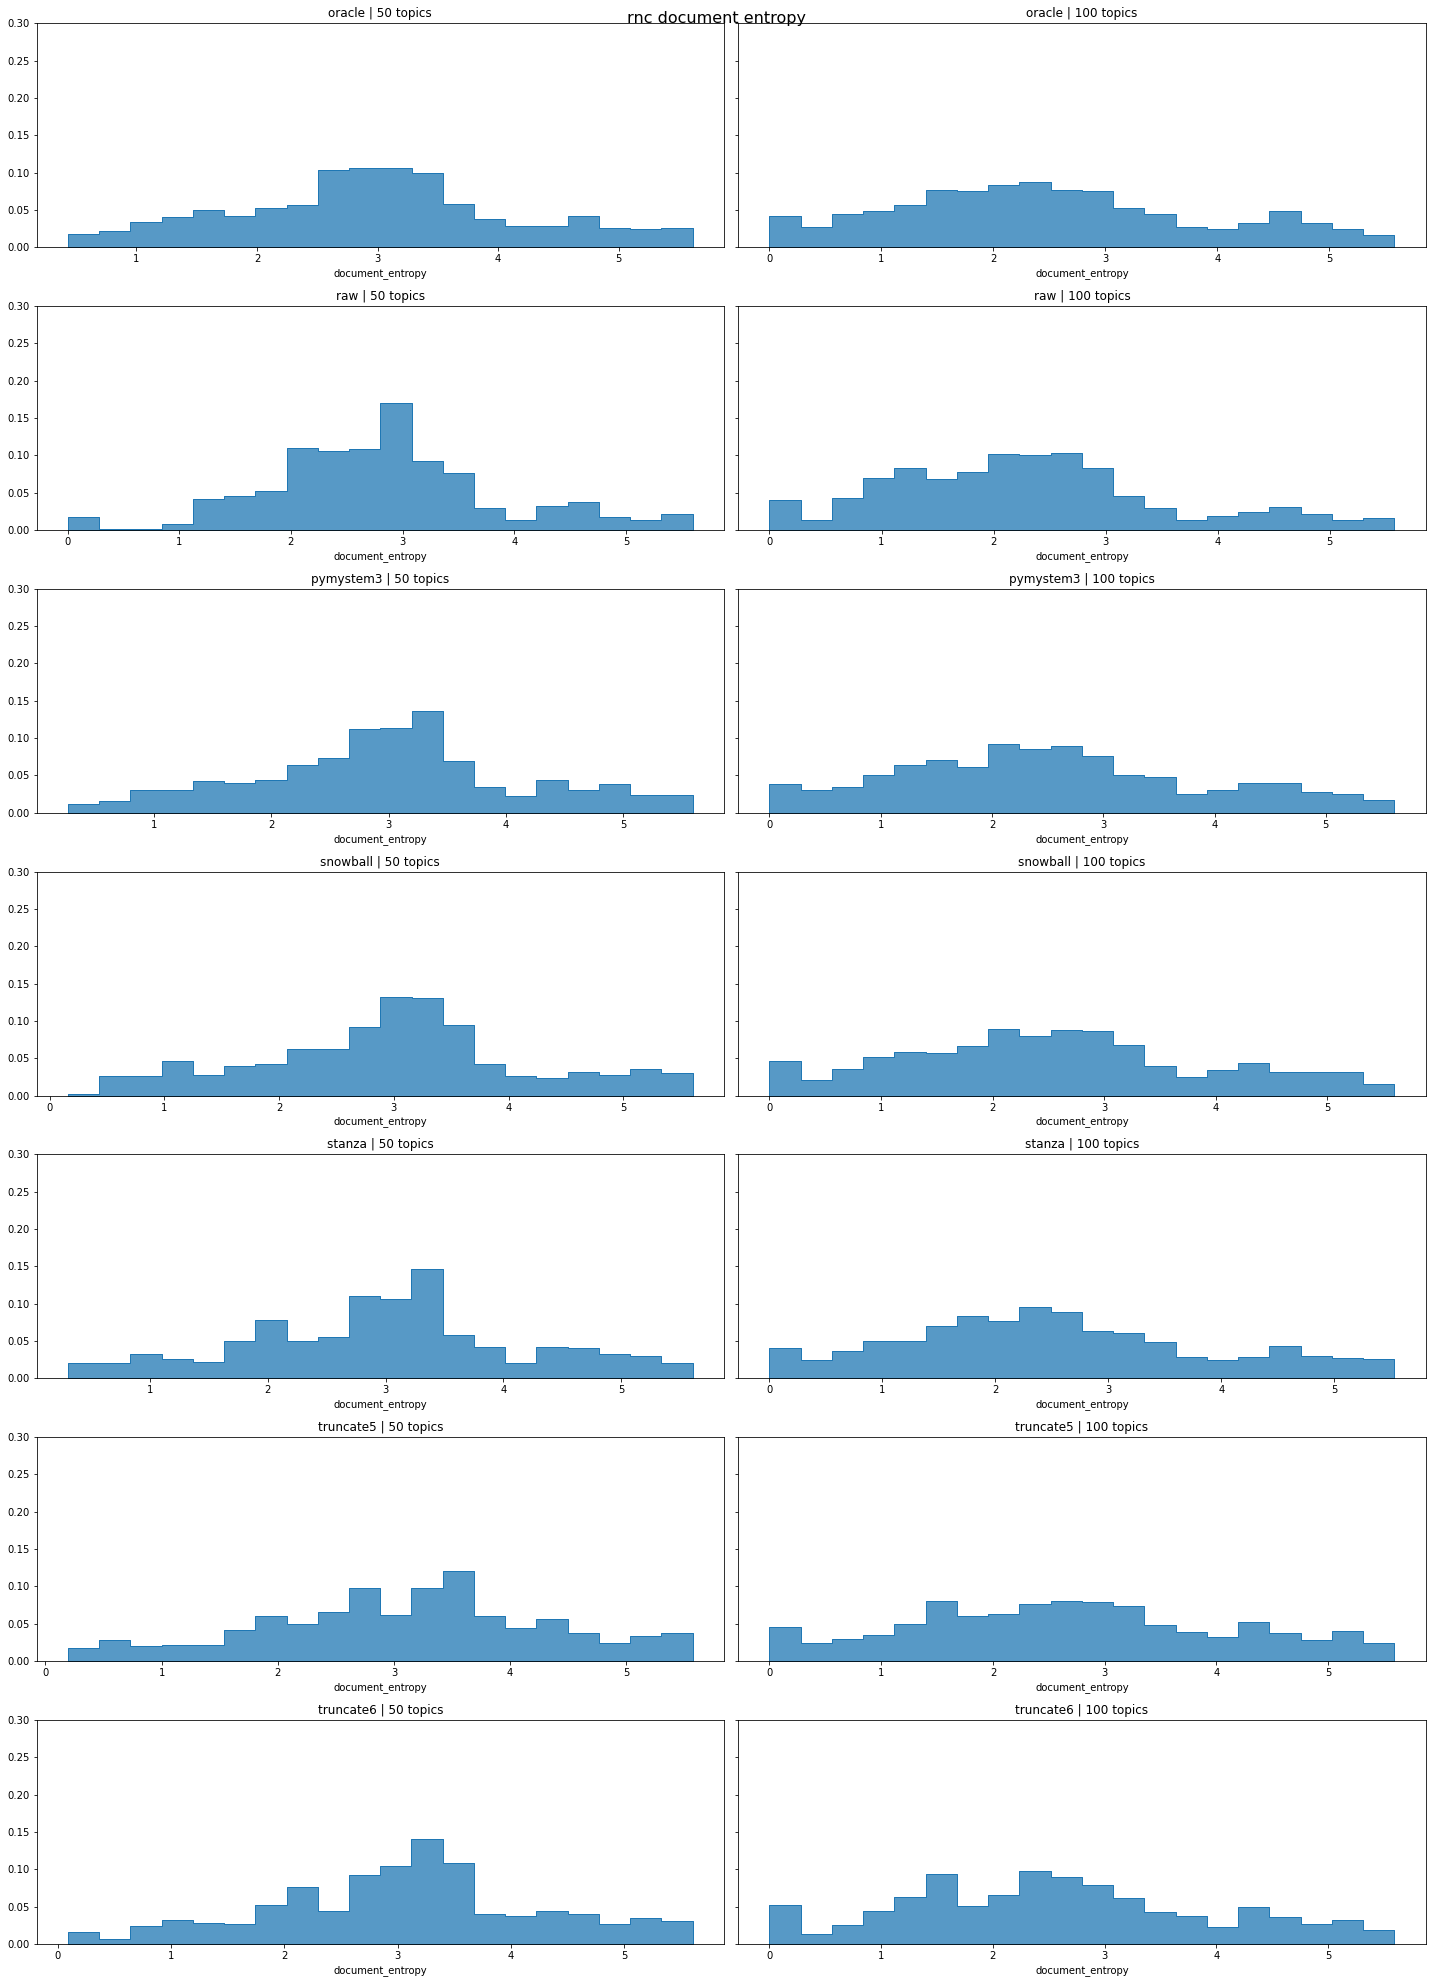

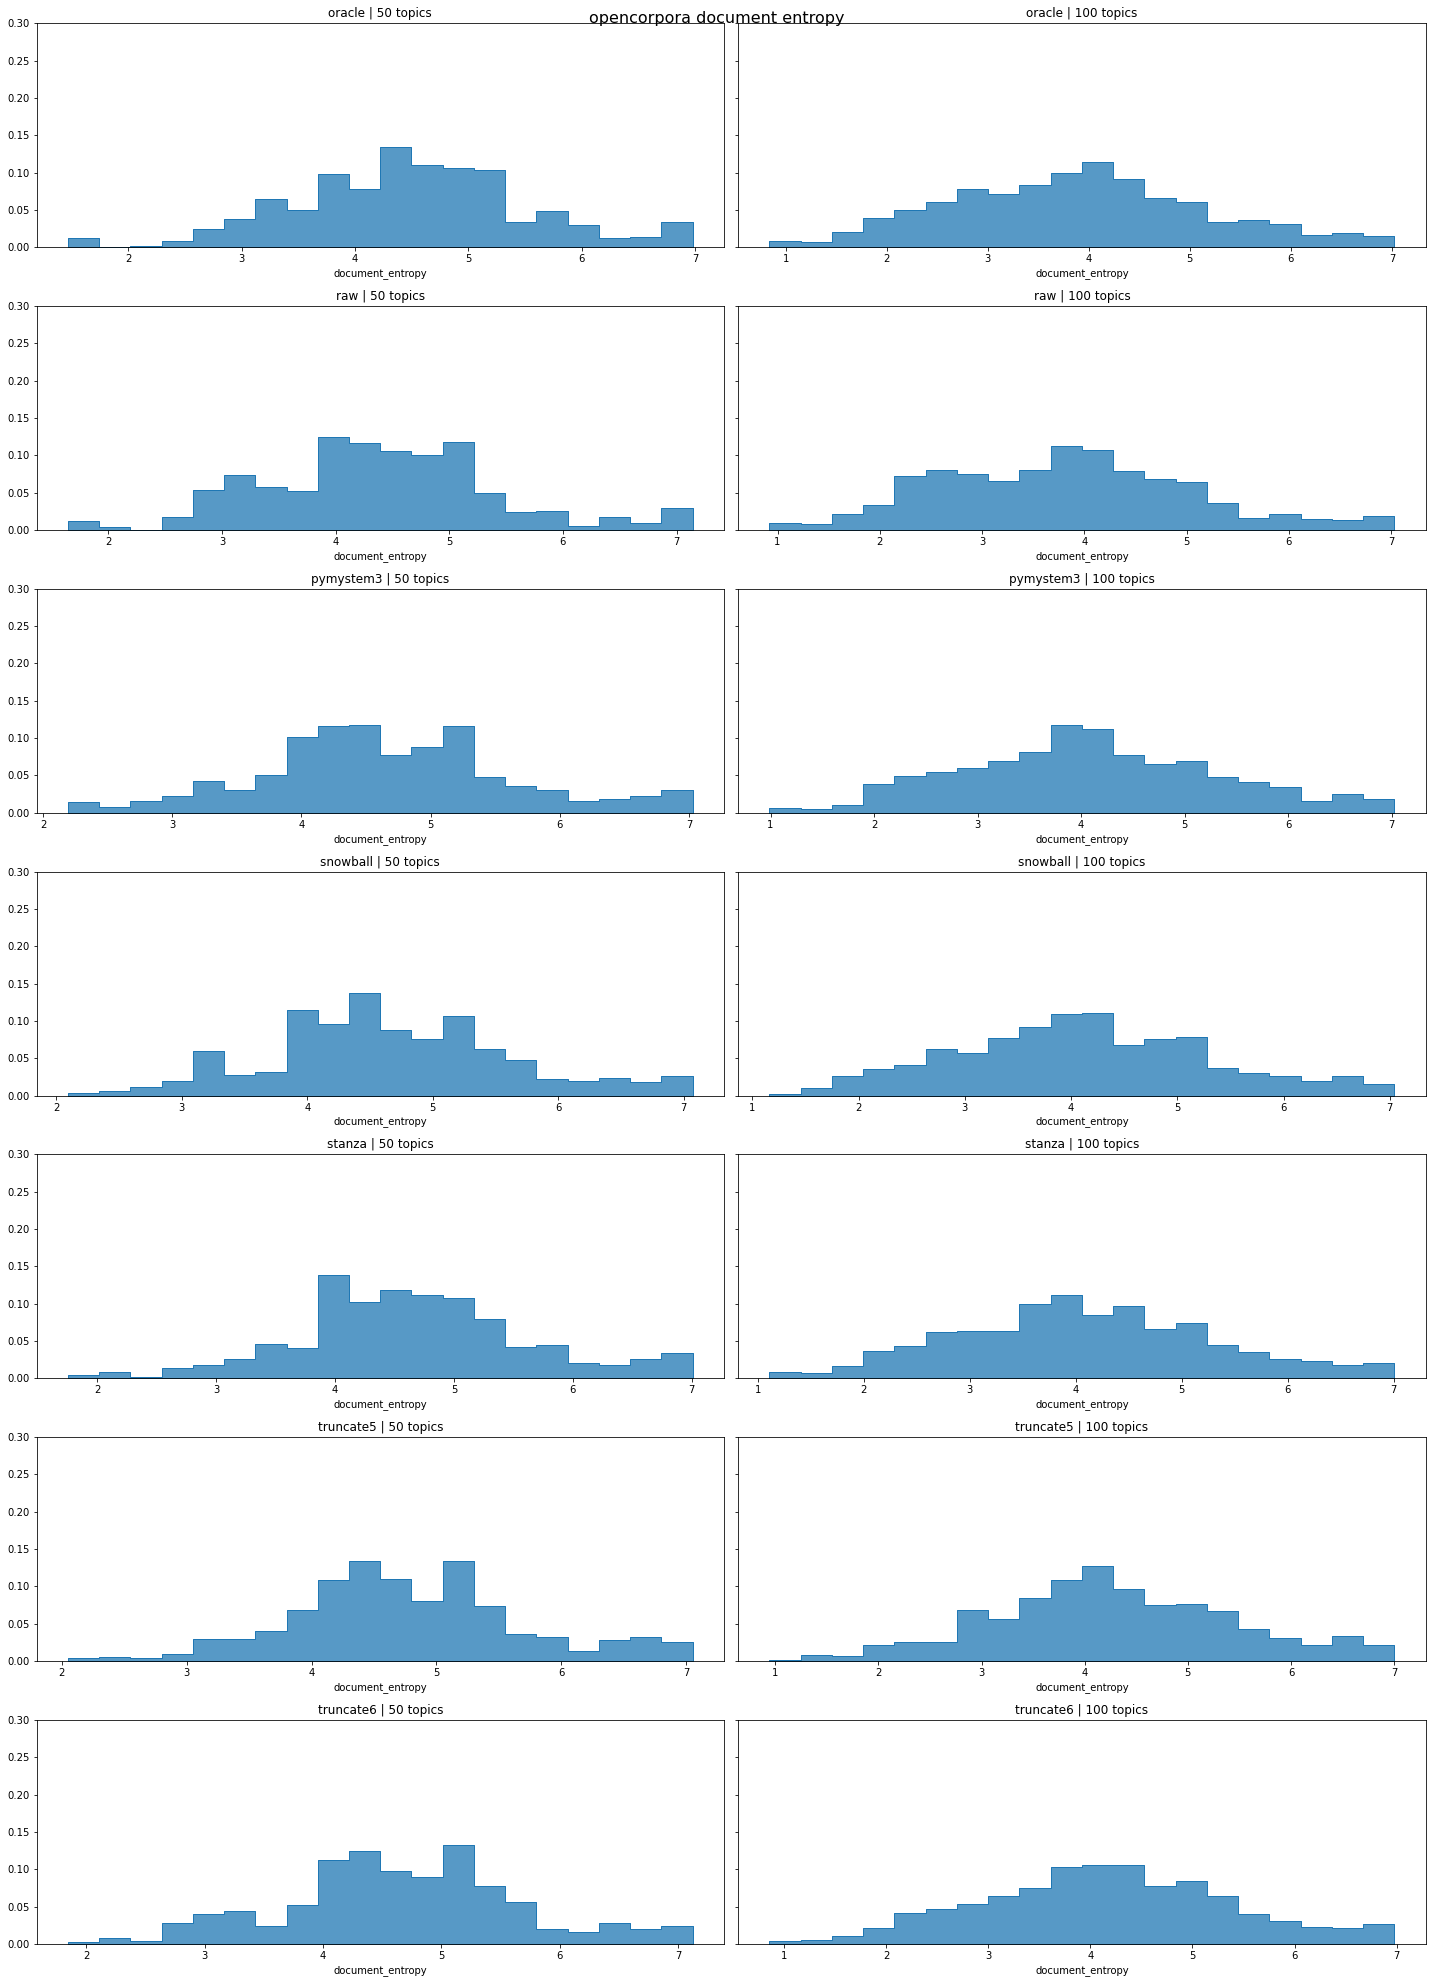

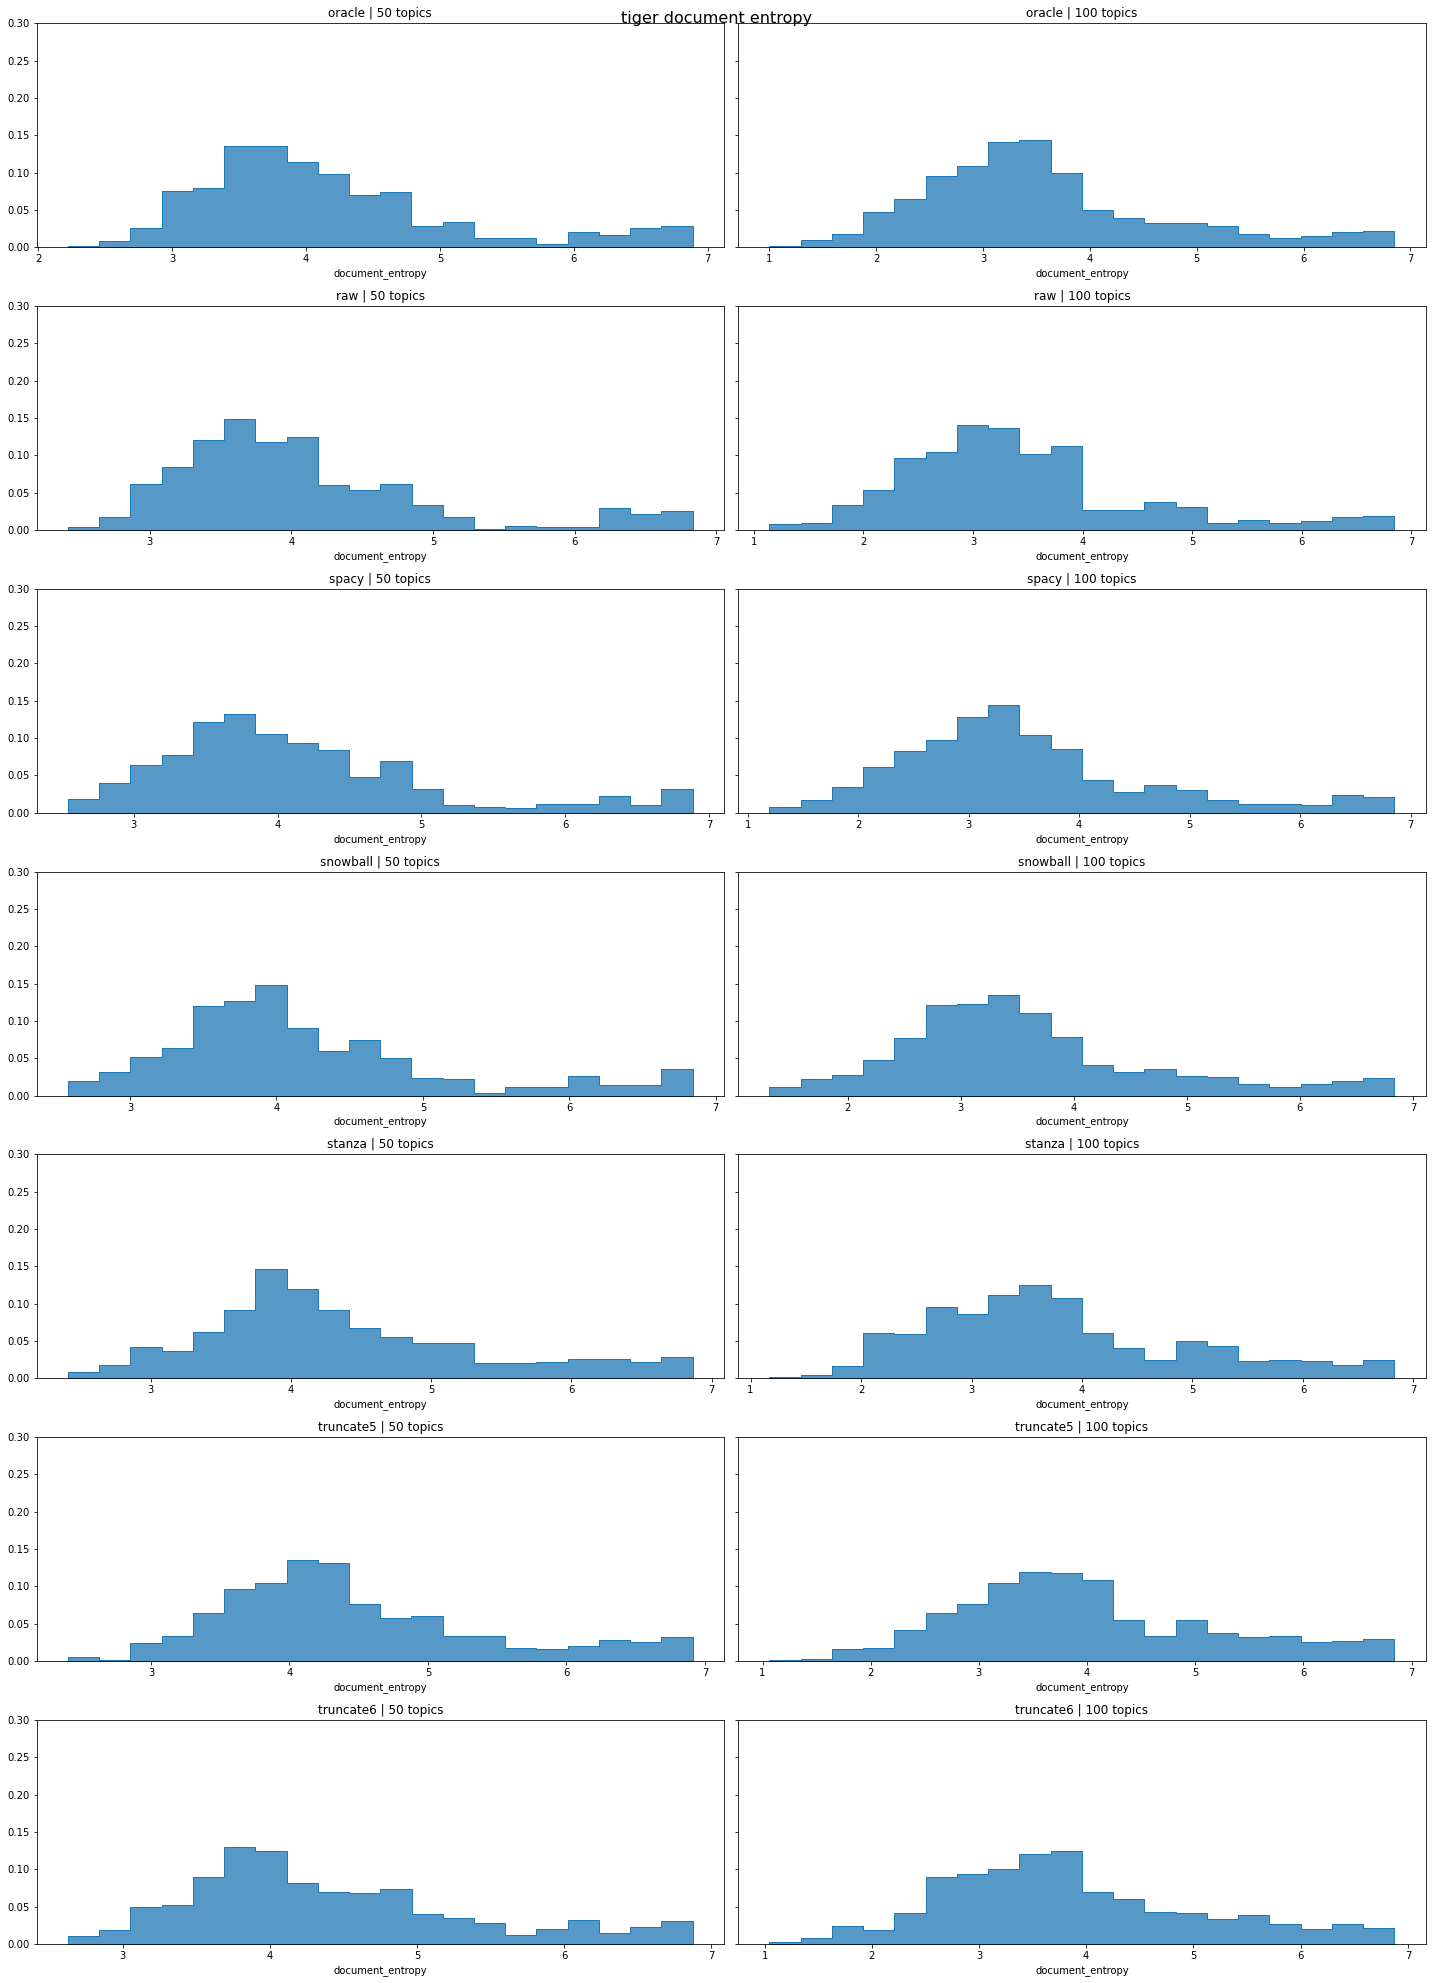

In [9]:
column ="document_entropy"
for c, lang in CORPORA.items():
    preprocs = PREPROCESSORS[lang]
    fig, axs = plt.subplots(ncols=len(NUM_TOPICS), nrows=len(preprocs))
    fig.set_figwidth(20)
    fig.set_figheight(28)
    fig.suptitle(f"{c} document entropy", fontsize=16)
    for j in range(len(preprocs)):
        p = preprocs[j]
        for i in range(len(NUM_TOPICS)):
            n = NUM_TOPICS[i]
            frames = [pd.read_csv(get_path_to_results(c,n,p,'diagnostics', count=k), sep='\t', encoding='utf-8', index_col=0) for k in range(NUM_EXPERIMENTS)]
            doc_ent_hist_data = pd.concat(frames)

            #author_data = pd.read_csv(get_path_to_results(n, p, 'author_correlation'), sep='\t', encoding='utf-8', index_col=0)

            tmp = sns.histplot(doc_ent_hist_data[column], ax=axs[j][i], bins=20, element='step', stat="probability")
            if p=="":
                tmp.set(title=f"{n} topics")
            else:
                tmp.set(title=f"{p} | {n} topics")

            if i != 0:
                pass
                plt.setp(axs[j][i].get_yticklabels(), visible=False)
            
            axs[j][i].set_ylim([0, 0.3])
            axs[j][i].set_ylabel("")
            
    plt.tight_layout()
    fig.tight_layout()
    plt.savefig(f"{c}_doc_entropy_all_treaments_hist.png")

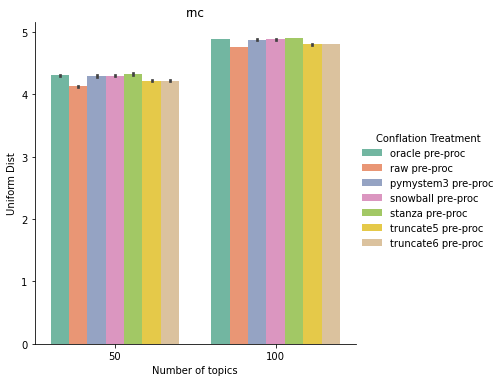

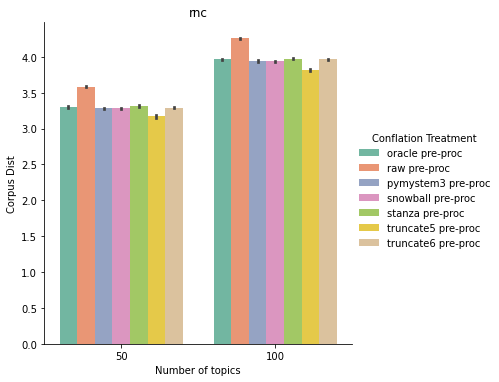

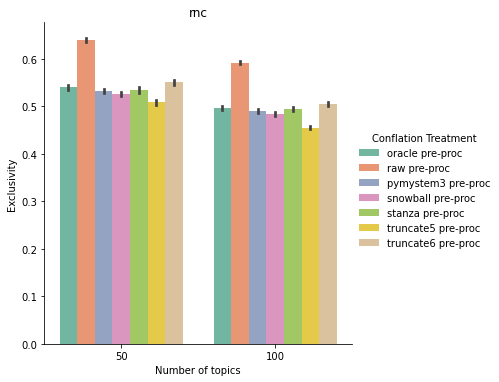

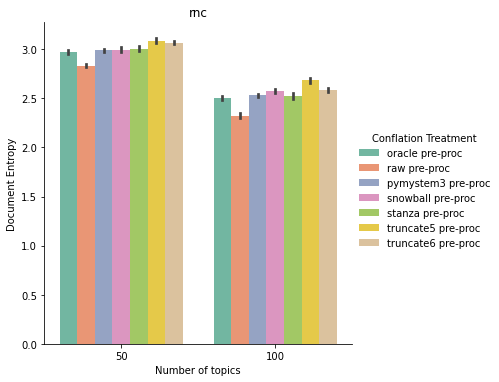

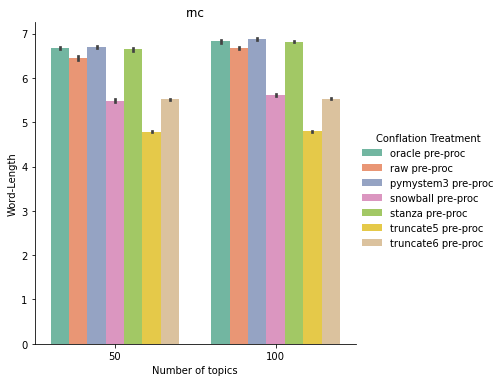

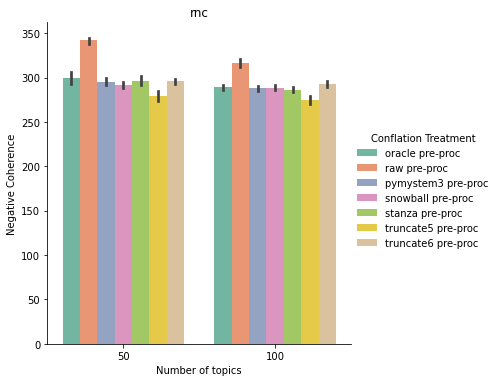

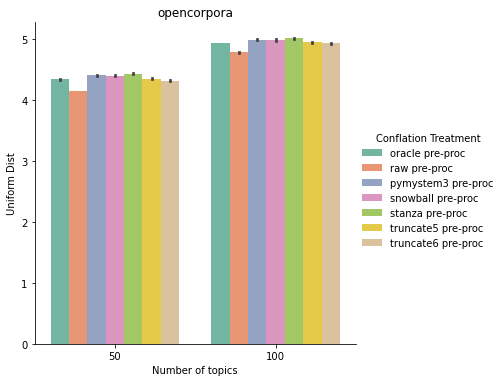

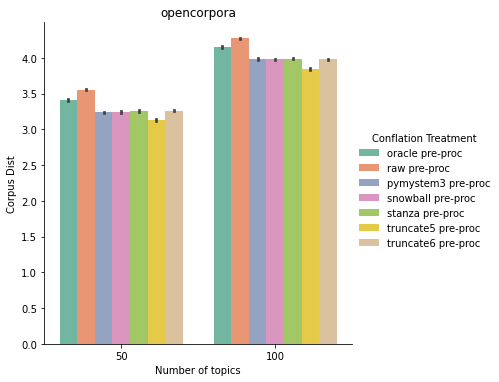

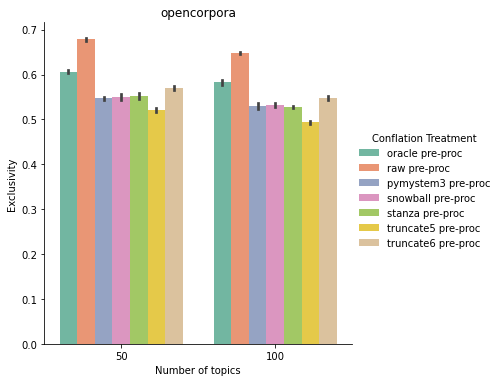

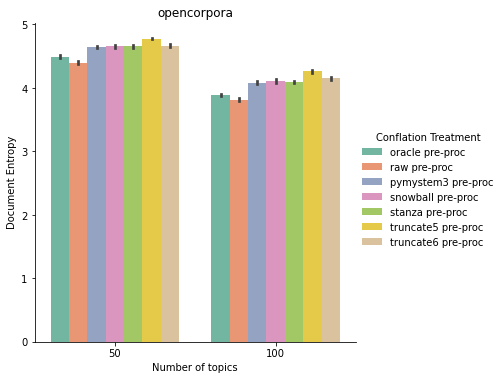

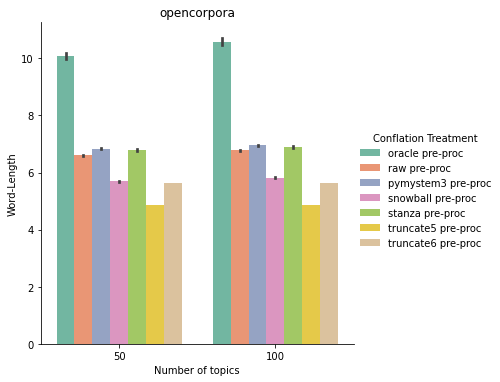

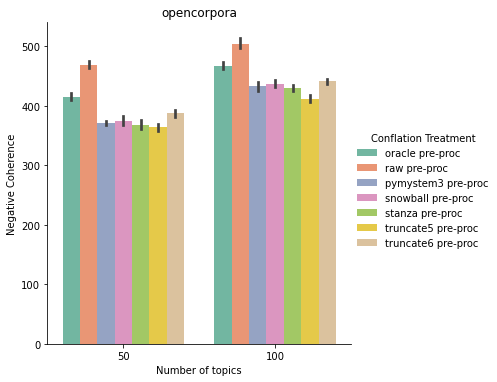

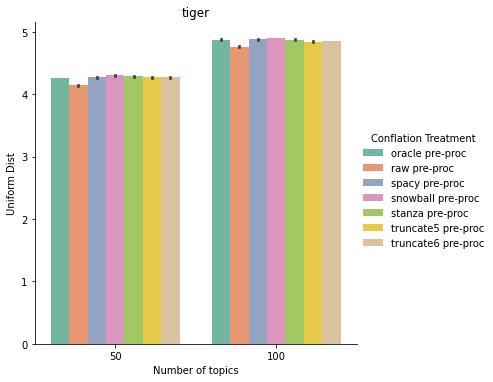

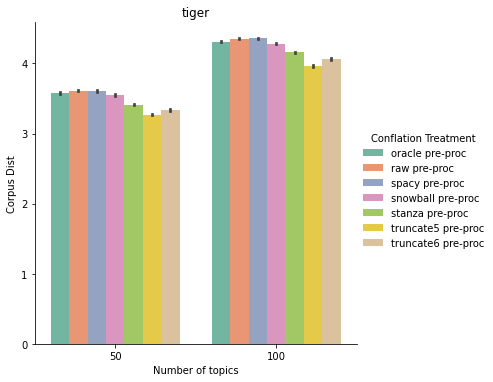

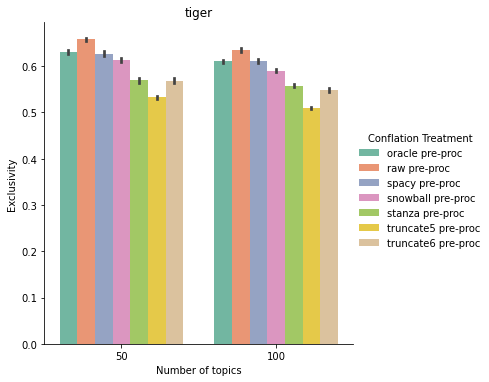

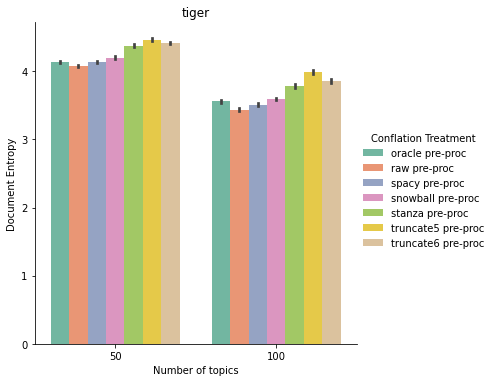

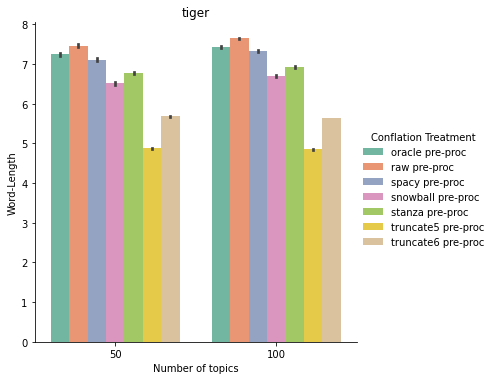

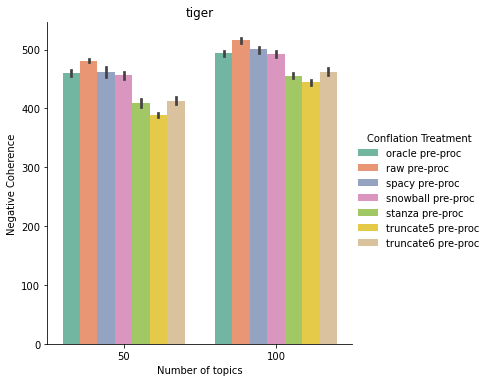

In [10]:

for c, lang in CORPORA.items():
    diagnostics_files = {}
    for i in NUM_TOPICS:
        results_files = defaultdict(list)
        for count in range(NUM_EXPERIMENTS):
            for p in PREPROCESSORS[lang]:
                if p=="":
                    k = "No treatment"
                else:
                    k = f"{p} pre-proc"
                results_files[k].append(get_path_to_results(c, i, p, 'diagnostics', False, count))
            #results_files["pymystem3 post-proc"].append(get_path_to_results(i, "", 'diagnostics', True, count))
            diagnostics_files[i] = results_files

    # coherence and other diagnostics
    metric_keys = ['uniform_dist', 'corpus_dist', 'exclusivity', 'document_entropy', 'word-length']
    doc_entropy_data = {"Conflation Treatment":[], "Document Entropy":[], "Number of topics":[]}
    plot_data = {'negative_coherence':[], "uniform_dist":[], "corpus_dist":[], "exclusivity":[], "Conflation Treatment":[], "document_entropy":[], "num_topics":[], 'word-length':[]}
    for i in NUM_TOPICS:
        results_files = diagnostics_files[i]
        for k,v_list in results_files.items():
            for v in v_list:
                diagnostics_data = pd.read_csv(v, sep='\t', encoding='utf-8', index_col=0)
                plot_data['Conflation Treatment'].append(k)
                plot_data['num_topics'].append(str(i))
                plot_data['negative_coherence'].append(-np.mean(diagnostics_data["coherence"]))
                doc_entropy_data["Conflation Treatment"].extend([k] * len(diagnostics_data))
                doc_entropy_data["Document Entropy"].extend(list(diagnostics_data["document_entropy"]))
                doc_entropy_data["Number of topics"].extend([i] * len(diagnostics_data))

                for m in metric_keys:
                    plot_data[m].append(np.mean(diagnostics_data[m]))

    plot_df = pd.DataFrame.from_dict(plot_data)
    for m in metric_keys + ['negative_coherence']:
        tmp = sns.catplot(data = plot_df, kind="bar", x="num_topics", y=m, hue="Conflation Treatment", palette='Set2')
        plt.title(c)
        tmp.set_axis_labels("Number of topics", m.replace("_", " ").title())
        plt.savefig(f"{c}_{m}.png")



    


In [15]:
for c, lang in CORPORA.items():
    # TODO Use facet grid to plot each value per 

    for p in PREPROCESSORS[lang]:
        ent_files = {}
        for i in NUM_TOPICS:
            results_files = [get_path_to_results(c, i, p, 'entropy_metrics', False, count) for count in range(NUM_EXPERIMENTS)]
            ent_files[i] = results_files

        # coherence and other diagnostics
        plot_results = {}

        metric_keys = ["slot_entropy", "lemma_entropy", "pos_entropy", 'lemmas_to_top_20_surface_forms', 'slots_to_top_20_surface_forms', 'pos_to_top_20_surface_forms' ]
        plot_data = defaultdict(list)
        for i in NUM_TOPICS:
            results_files = ent_files[i]
            for v in results_files:
                ent_data = pd.read_csv(v, sep='\t', encoding='utf-8', index_col=0)
                plot_data['Number of topics'].extend([str(i)]*len(ent_data))
                for m in metric_keys:
                    plot_data[m].extend((list(ent_data[m])))


        plot_df = pd.DataFrame.from_dict(plot_data)
        for m in metric_keys:
            plt.figure()
            tmp = sns.violinplot(data = plot_df, x="Number of topics", y=m, palette='colorblind')
            newy=m
            tmp.set(ylabel=newy.replace("_", " ").title())
            tmp.set_title(f"{c} {p}")
            plt.savefig(f"{m}.png")

        plt.figure()
        tmp = sns.scatterplot(data=plot_data, x = "lemma_entropy", y="slot_entropy", hue="Number of topics", style="Number of topics", alpha=0.4, palette='colorblind')
        tmp.set(xlabel="Lemma Entropy", ylabel="Slot Entropy")
        tmp.set_title(f"{c} {p}")
        plt.savefig(f"{c}_{p}_lemma_slot_entropy_scatter.png")

        plt.figure()
        tmp = sns.scatterplot(data=plot_data, x = "lemmas_to_top_20_surface_forms", y="slots_to_top_20_surface_forms", hue="Number of topics", palette='colorblind')
        tmp.set(xlabel="Lemmas to Top 20 Surface Forms", ylabel="Slots to Top 20 Surface Forms")
        tmp.set_title(f"{c} {p}")
        plt.savefig(f"{c}_{p}_lemma_slot_ratio_scatter.png")


SyntaxError: EOL while scanning string literal (<ipython-input-15-d7643860faa8>, line 30)